In [1]:
import jax.numpy as np
import jax
jax.config.update("jax_debug_nans", True)
jax.config.update('jax_platform_name', 'cpu')

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import razor

class model(razor.Model):
    def forward(self, t, m):  # here, "t" is the "trace" object used by the PPL's compiler
        T = t.gaussian_sample((), 70., 5)
        t.gaussian_observe(T, 2., m)
model = model(0.)  # 0. is a dummy value for m, just used for shape inference

E[T | M=100] ~= 95.95879364013672


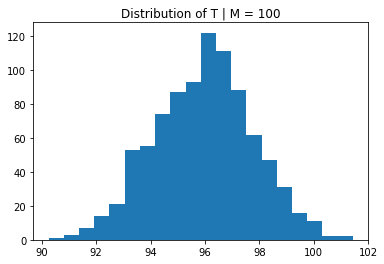

In [3]:
q0 = np.zeros(model.N)
key = jax.random.PRNGKey(0)
samples = razor.hmc_sample(
    model, q0, key, 1000, 300, 0, 1e-2,  # hyperparameters
    100.  # value of M to condition on
)
plt.hist(samples[100:, 0], bins=20); plt.title('Distribution of T | M = 100')
print(f'E[T | M=100] ~= {samples[100:, 0].mean()}')

In [4]:
# Loss function. q0 is the initial particle state for HMC.
def loss(m, key, q0):
    samples = razor.hmc_sample(model, q0, key, 1000, 300, 0, 1e-2, m)
    samples = samples[100:]
    mu = samples.mean()
    return (mu - 100.0) ** 2, samples
dloss = jax.value_and_grad(loss, argnums=0, has_aux=True)

# Optimization loop
key = jax.random.PRNGKey(0)
m = np.array(0.)  # initial value for gradient descent
for i in tqdm(range(100)):
    key, subkey = jax.random.split(key)
    q0 = jax.random.normal(key=subkey, shape=(model.N,))
    key, subkey = jax.random.split(key)
    (l, s), dl = dloss(m, subkey, q0)
    print(f'Step {i:2d}: E[T | M={m:7.03f}] ~= {s.mean():7.03f} (loss = {l:9.4f})')
    m = m - 0.1 * dl

  0%|          | 0/100 [00:00<?, ?it/s]

Step  0: E[T | M=  0.000] ~=   9.595 (loss = 8173.0127)
Step  1: E[T | M= 15.587] ~=  23.053 (loss = 5920.8770)
Step  2: E[T | M= 28.854] ~=  34.511 (loss = 4288.8687)
Step  3: E[T | M= 40.145] ~=  44.147 (loss = 3119.5610)
Step  4: E[T | M= 49.775] ~=  52.580 (loss = 2248.6382)
Step  5: E[T | M= 57.950] ~=  59.614 (loss = 1630.9949)
Step  6: E[T | M= 64.913] ~=  65.585 (loss = 1184.3597)
Step  7: E[T | M= 70.847] ~=  70.731 (loss =  856.6827)
Step  8: E[T | M= 75.893] ~=  75.094 (loss =  620.3095)
Step  9: E[T | M= 80.188] ~=  78.922 (loss =  444.2906)
Step 10: E[T | M= 83.822] ~=  81.859 (loss =  329.0795)
Step 11: E[T | M= 86.950] ~=  84.592 (loss =  237.3998)
Step 12: E[T | M= 89.606] ~=  86.905 (loss =  171.4823)
Step 13: E[T | M= 91.864] ~=  88.772 (loss =  126.0592)
Step 14: E[T | M= 93.800] ~=  90.447 (loss =   91.2534)
Step 15: E[T | M= 95.447] ~=  91.966 (loss =   64.5433)
Step 16: E[T | M= 96.832] ~=  93.105 (loss =   47.5423)
Step 17: E[T | M= 98.021] ~=  94.152 (loss =   3